### Notebook for the label transfer of Healthy-CTRL to rest of samples and conditions with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- v221129

### Import required modules

In [21]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 9.3.0
absl                NA
appnope             0.1.4
asttokens           NA
attr                23.2.0
chex                0.1.85
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2023.4.0
h5py                3.10.0
igraph              0.11.4
importlib_resources NA
ipykernel           6.29.3
ipywidgets          8.1.2
jax                 0.4.25
jaxlib              0.4.25
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
legacy_api_wrap     NA
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
ml_collections      NA
ml_dtypes           0.3.2
mpl_toolkits        N

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in Healthy data

In [5]:
scCOPD_All = sc.read_h5ad('/Users/cartalop/github/COPD_influenza/data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad')
scCOPD_All

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [6]:
scCOPD_All.obs['group'].value_counts()

group
copd_ctrl       26261
copd_iav        24958
healthy_ctrl    23667
healthy_iav     22687
Name: count, dtype: int64

In [7]:
scCOPD_All.obs['cell_states'].value_counts()

cell_states
NOTCH3+SupraB                10353
MKI67+pBasal                  8384
FB-like_Basal                 7109
IGFBP+Basal                   6594
KRT14+Goblet                  5885
CCDC3+Basal1                  5727
MUC5B+Goblet                  5073
KRT17+Goblet                  4358
ifn_Basal                     3761
mixed_Goblet1                 3194
KRT14+AQP1+Secretory          3185
iav_Goblet                    2976
mixed_Goblet2                 2647
MHCII+Club                    2474
S100A2+Basal                  2412
ImmuneClub                    2336
SCGB1A1+Goblet                2184
DHRS9+Club                    1934
OMG+Ciliated                  1871
NOTCH+Basal2                  1721
iavAPC_Epi                    1498
SERPINE1+Basal                1401
SERPINE2+Basal                1180
TNC+Basal                     1117
ifn_Goblet                    1035
RARRES1+lip_Goblet             913
iav-lip_Club                   880
IGFBP6+Basal                   861
APOD+Cil

### Split by conditions

In [8]:
reference = scCOPD_All[scCOPD_All.obs['group'].isin(['healthy_ctrl'])]
reference.obs['seed_labels'] = reference.obs['cell_states'].copy()
reference

AnnData object with n_obs × n_vars = 23667 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [9]:
reference.obs['seed_labels'].value_counts()

seed_labels
NOTCH3+SupraB                2550
MUC5B+Goblet                 2335
MKI67+pBasal                 2248
FB-like_Basal                1608
KRT14+Goblet                 1605
IGFBP+Basal                  1594
CCDC3+Basal1                 1562
KRT17+Goblet                 1442
KRT14+AQP1+Secretory          973
iav_Goblet                    896
mixed_Goblet2                 888
mixed_Goblet1                 870
ImmuneClub                    790
SCGB1A1+Goblet                717
OMG+Ciliated                  605
S100A2+Basal                  585
NOTCH+Basal2                  431
SERPINE2+Basal                396
APOD+Ciliated                 314
p53_Ciliated                  225
TNC+Basal                     214
SCGB1A1+Deutero               202
IGFBP6+Basal                  187
TCN1+Club                     143
Ionocyte                      141
RARRES1+lip_Goblet             82
KRT16+SupraB                   15
MHCII+Club                     12
DHRS9+Club                     11
ia

In [10]:
query = scCOPD_All[~scCOPD_All.obs['group'].isin(['healthy_ctrl'])]
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 73906 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [11]:
query.obs['seed_labels'].value_counts()

seed_labels
Unknown    73906
Name: count, dtype: int64

In [12]:
adata = reference.concatenate(query, batch_key = 'batch-scANVI', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch-scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

### Perform further QC-filtering from prior exploratory analyses

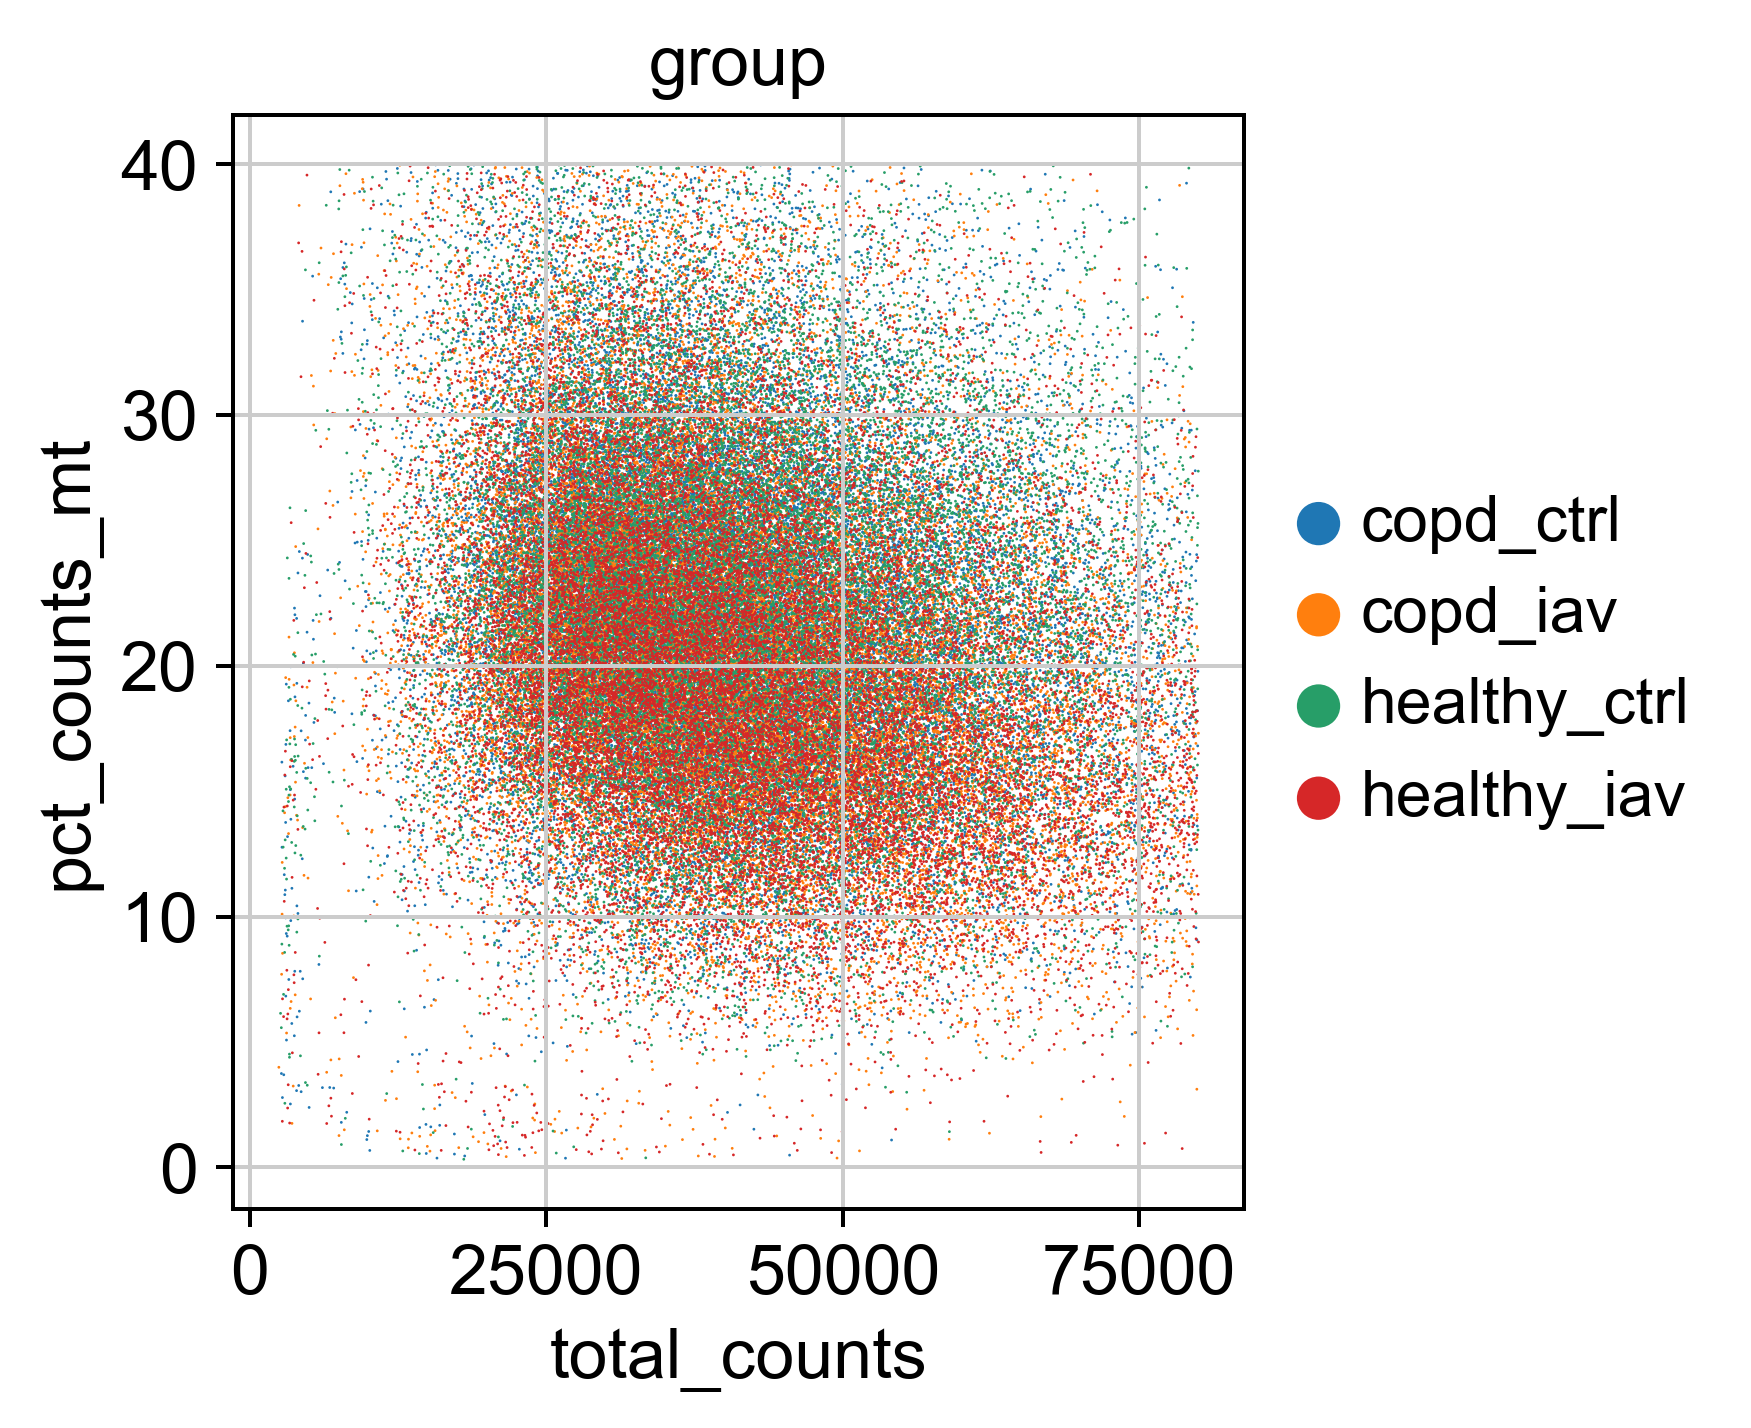

In [13]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt', color = "group", frameon = False)

In [14]:
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'group_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

### Select HVGs

In [15]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)
adata

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 97573 × 8000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch-scANVI'
    var: 'mt', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'group_colors', 'hvg'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'

### Transfer of annotation with scANVI

In [16]:
scvi.model.SCVI.setup_anndata(adata,
                              batch_key = "donor", 
                            categorical_covariate_keys = ["illumina_stimunr"], 
                            labels_key = "seed_labels", 
                            layer = 'counts')

In [17]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 150, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [18]:
scvi_model.train(60, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = 'mps',
                 devices = [0])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 60/60: 100%|██████████| 60/60 [12:17<00:00, 12.15s/it, v_num=1, train_loss_step=2.38e+3, train_loss_epoch=2.82e+3]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████| 60/60 [12:17<00:00, 12.29s/it, v_num=1, train_loss_step=2.38e+3, train_loss_epoch=2.82e+3]


In [19]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance using the Svensson method

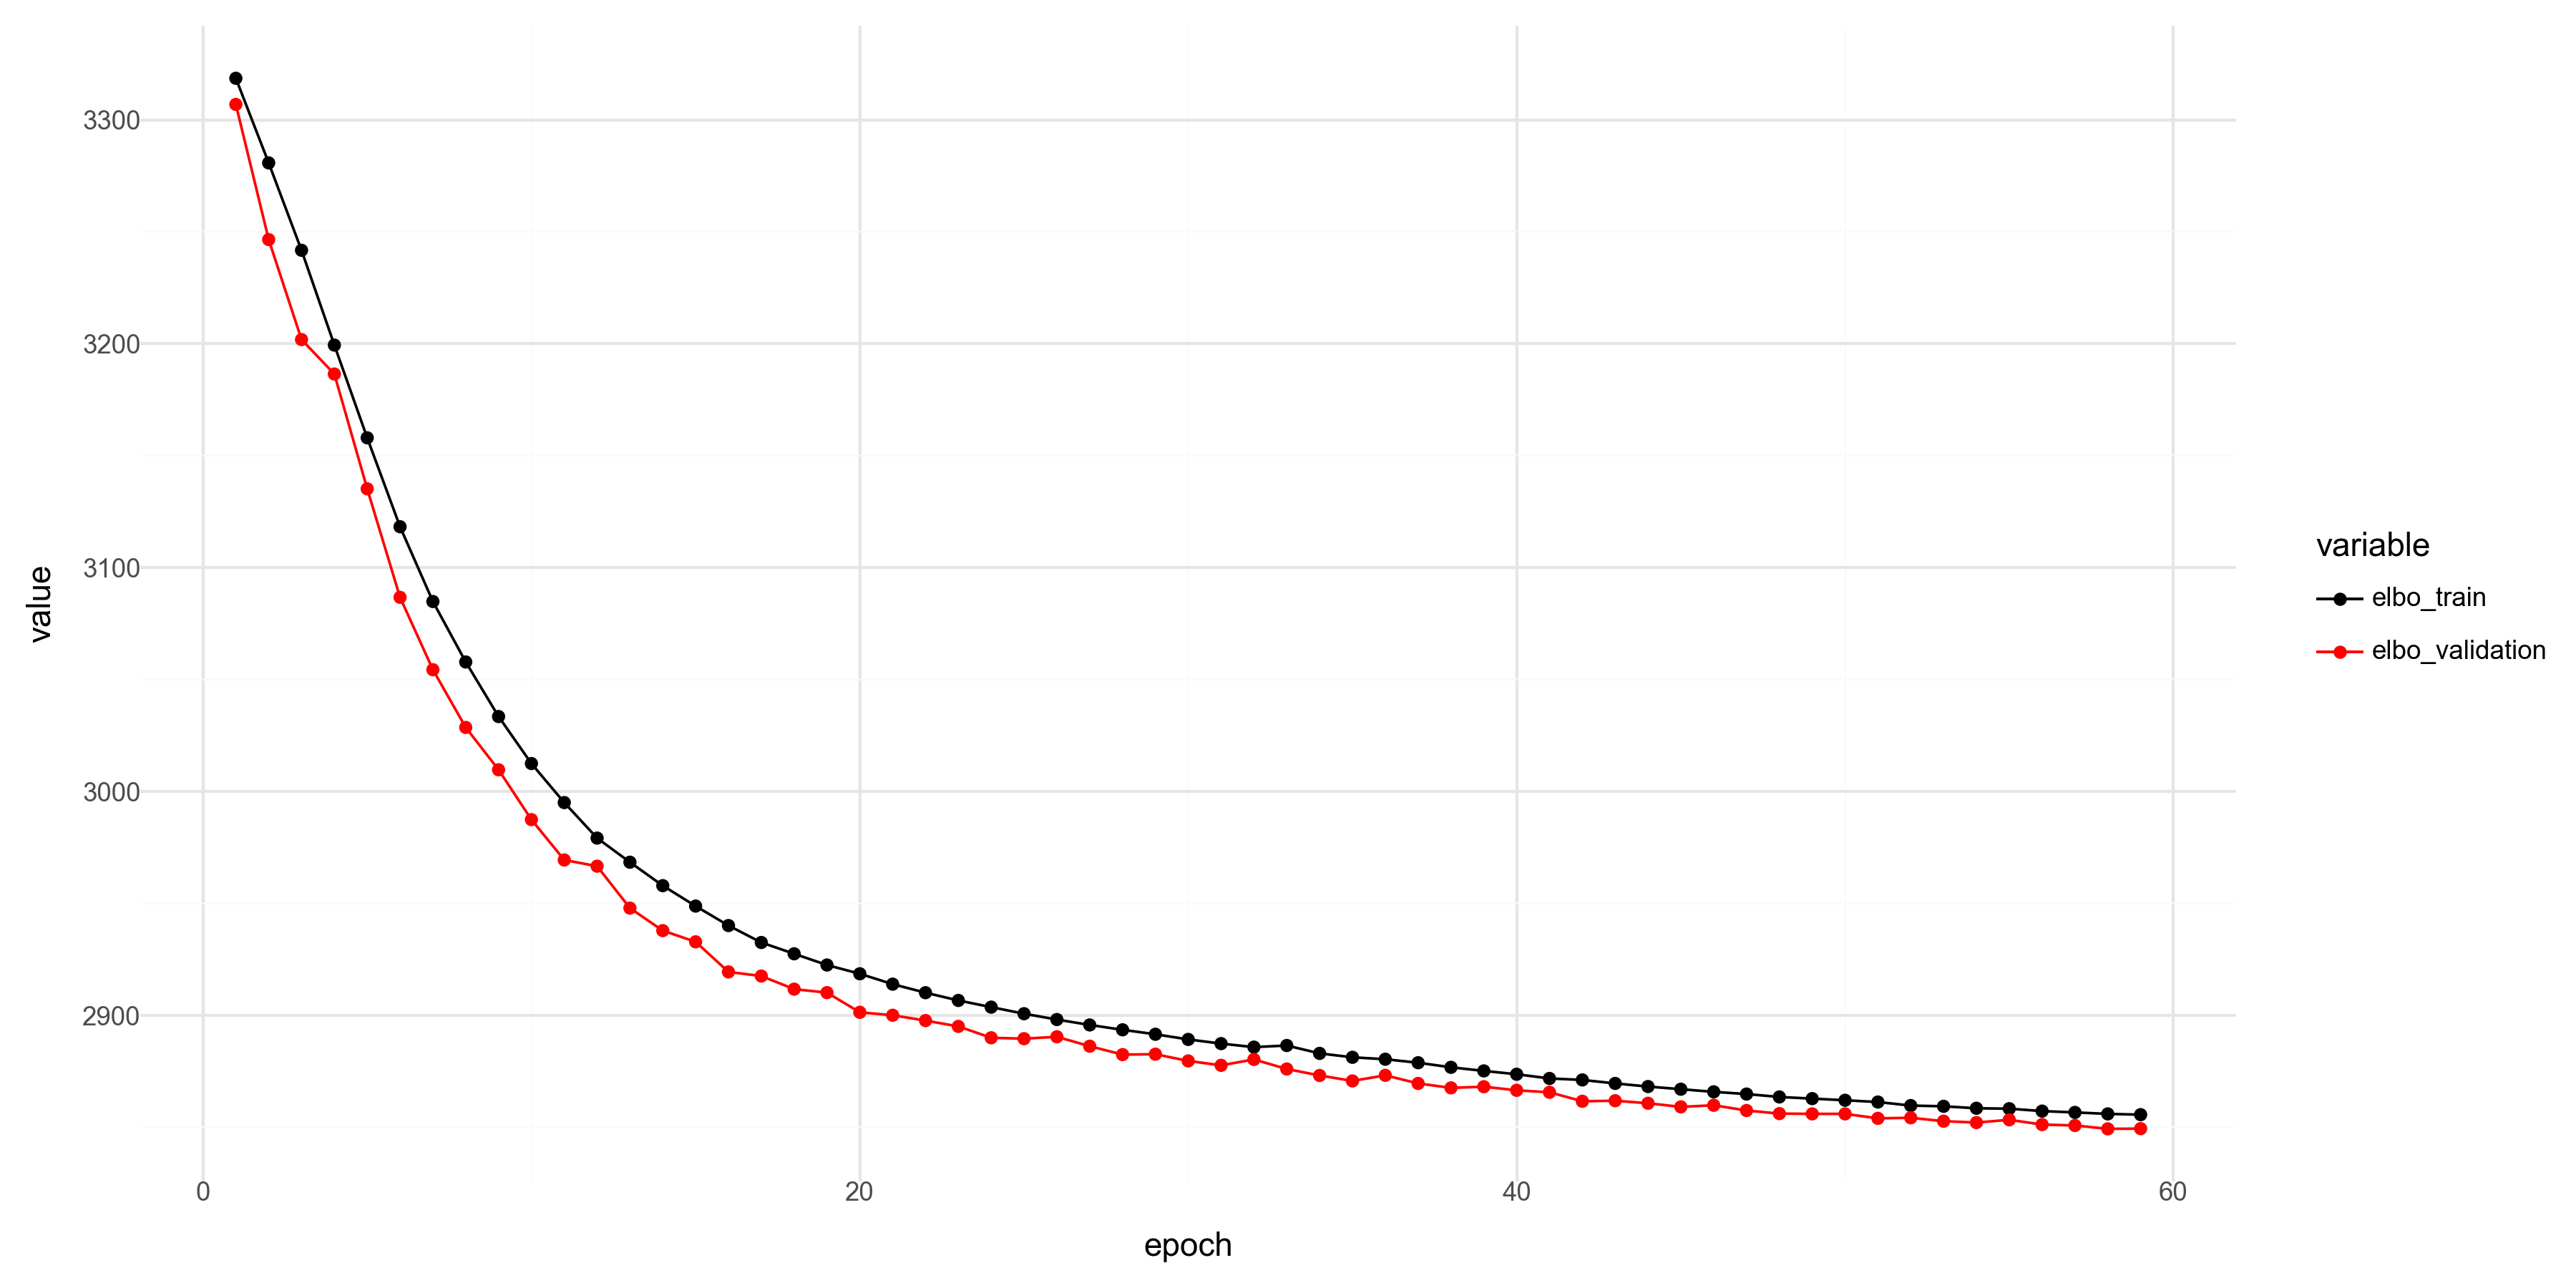

In [22]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [23]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [24]:
scanvi_model.train(15, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True, 
                   accelerator = 'mps',
                   devices = [0])

INFO     Training for 15 epochs.                                                                                   


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 15/15: 100%|██████████| 15/15 [10:54<00:00, 42.99s/it, v_num=1, train_loss_step=3.05e+3, train_loss_epoch=2.82e+3]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [10:54<00:00, 43.63s/it, v_num=1, train_loss_step=3.05e+3, train_loss_epoch=2.82e+3]


In [25]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

In [26]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the Svensson method

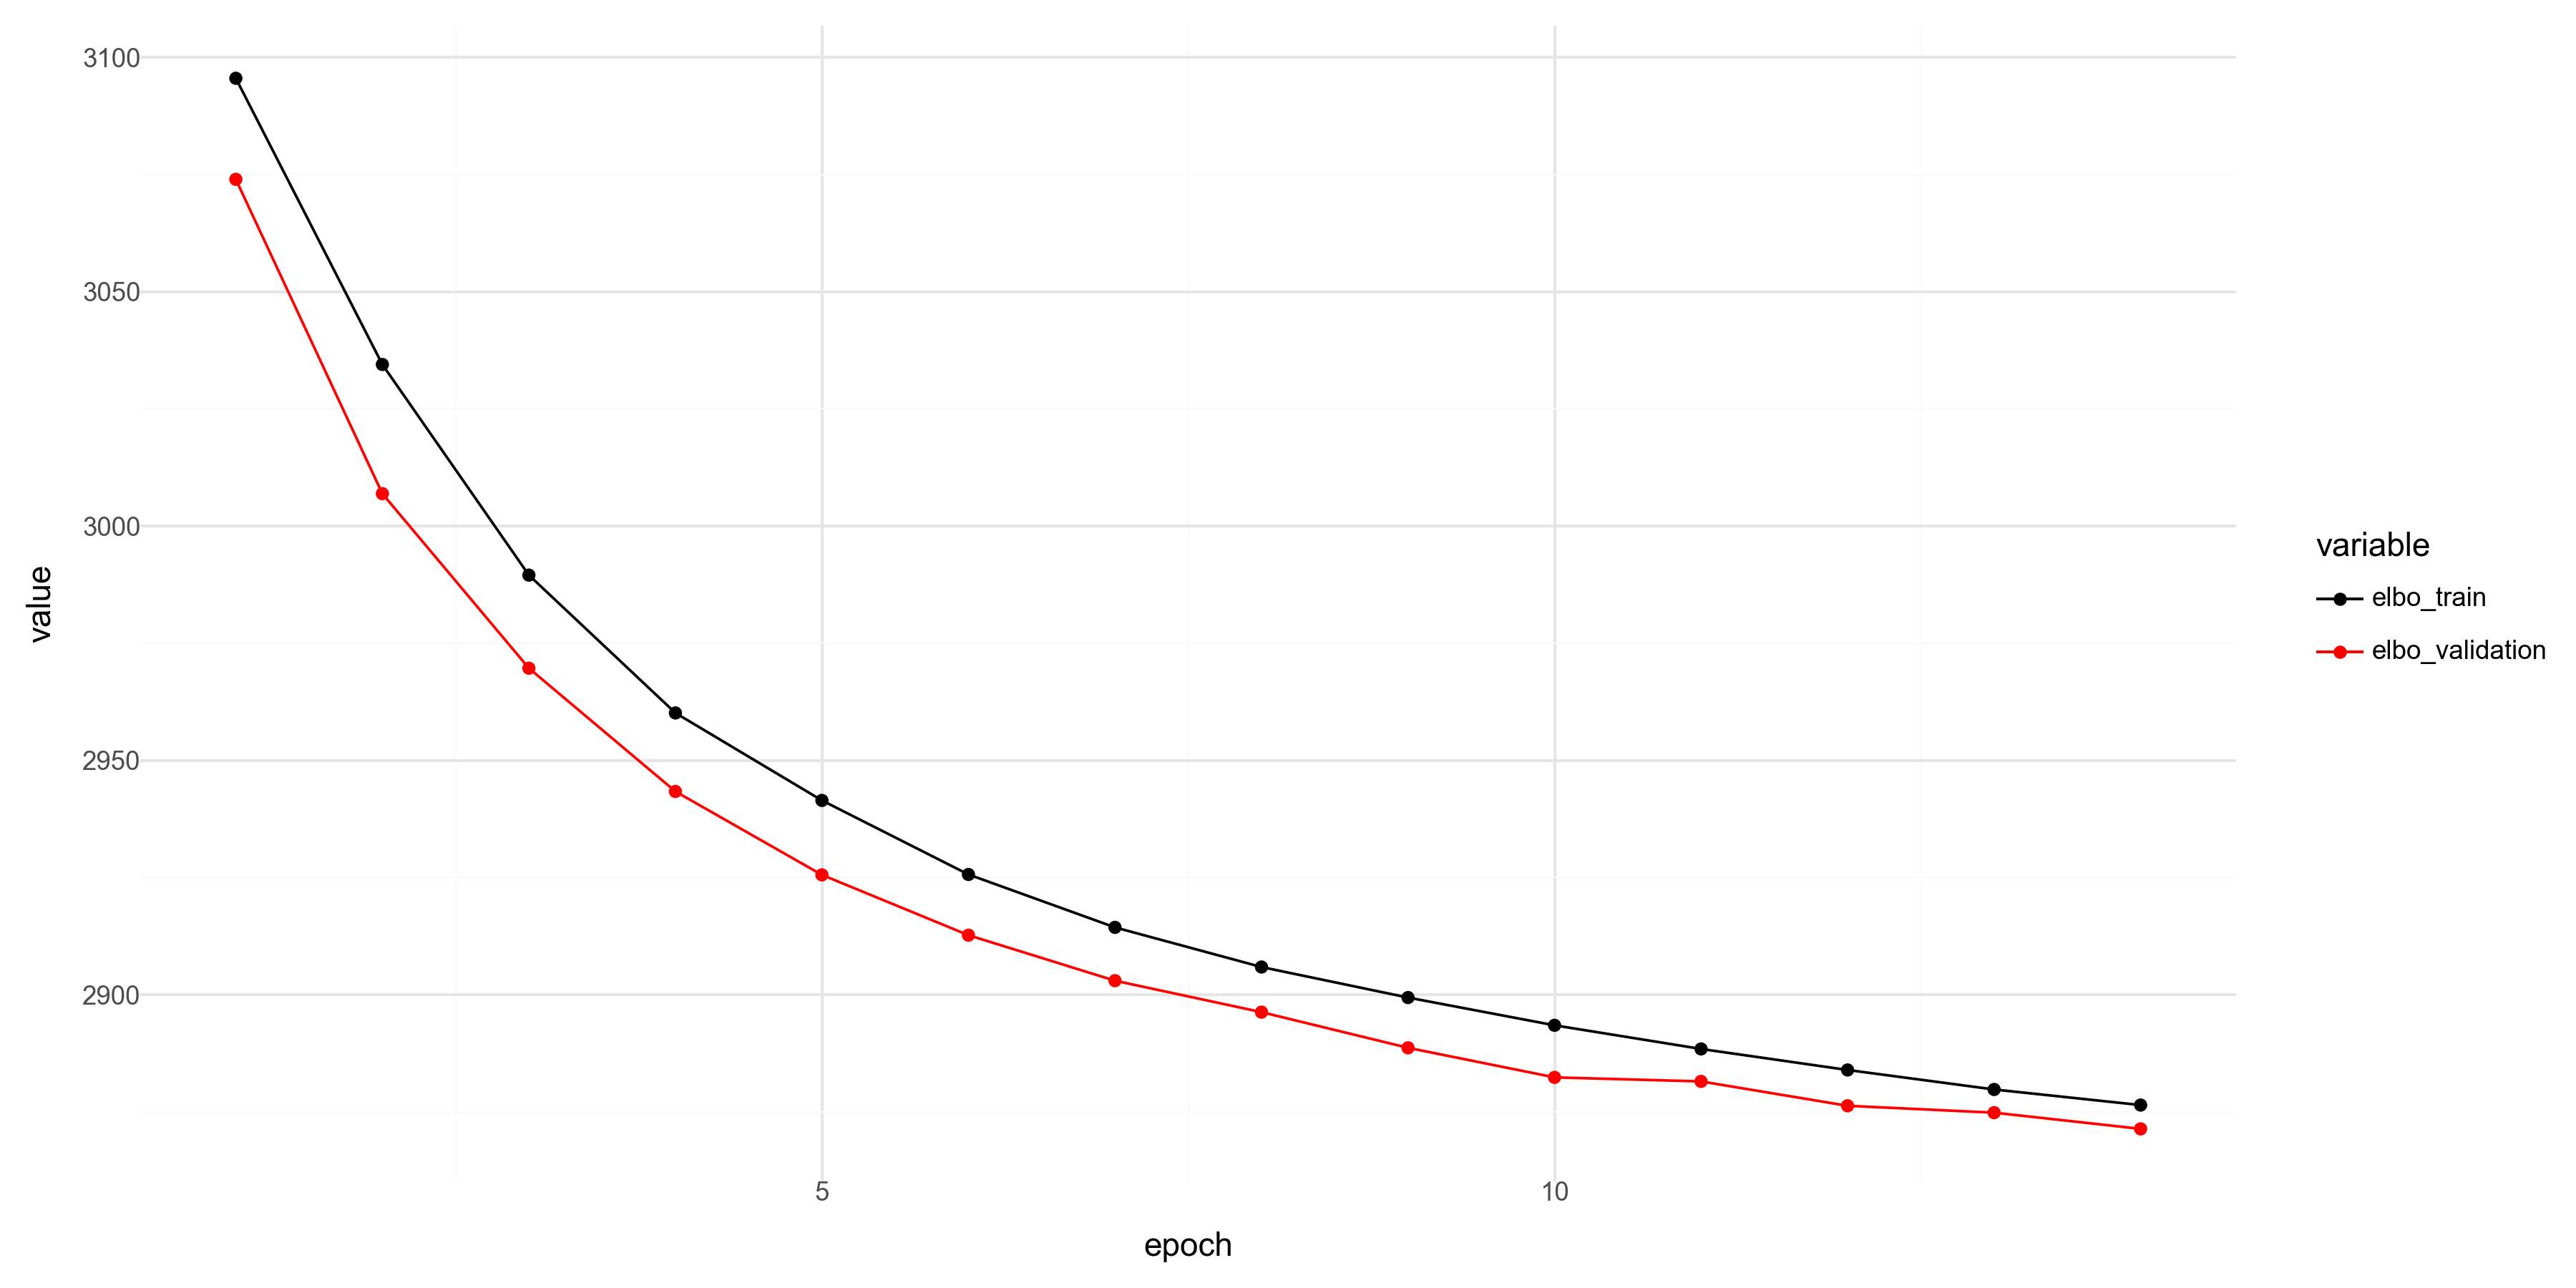

In [27]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Visualise corrected dataset

In [28]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 150, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['group', 'disease', 'infection', 'C_scANVI', 'seed_labels', 'donor', 'bd_rhapsody', 'illumina_stimunr'], size = 1, legend_fontsize = 5, ncols = 4)

computing neighbors


In [ ]:
sc.pl.umap(adata, frameon = False, color = ['SMK', 'n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'sample_group', 'IAV_score'], size = 1, legend_fontsize = 5, ncols = 4, cmap = 'plasma')

### Compute integration metrics

In [ ]:
bm = Benchmarker(
    adata,
    batch_key = ["illumina_stimunr", "donor", "sample_group"],
    label_key = "C_scANVI",
    embedding_obsm_keys = ["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale = False)

### Export annotated sample object 

In [ ]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export